<a href="https://colab.research.google.com/github/ZsofiaK/masterthesis/blob/main/Programming%20exercise/Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kick-off Programming Exercise
Preparation for Master's Thesis - Zsófia Katona

This notebook contains the implementation of a simple two-layer neural network.

In [1]:
# Import libraries.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

2024-01-08 11:21:35.861415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Generating input data

We use *n* samples of 3-dimensional data with width x height x channel = W x H x C (e.g., a colored image with a resolution of W x H pixels).

The labels come from the set [0, 1, ..., K-1].

The sample is randomly generated.

In [ ]:
# Setting the properties of the sample.
n = 1000
W = 4
H = 5
C = 3
K = 3

# Generating input data.
data = torch.randn(n, C, W, H)

# Generating labels.
labels = torch.randint(0, K, (n,))

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=23)

## Defining our model

Our model is a 2-layer neural network with the following layers:
1. 2D Convolutional Layer with ReLU activation
2. Fully connected layer

In [ ]:
class TwoLayerNetwork(nn.Module):
    '''A 2-layer neural network with 2D Convolution + ReLU + Fully Connected Layer.'''

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * W * H, K)

    def forward(self, input):
        output = self.conv1(input)
        output = self.relu(output)
        output = self.flatten(output)
        output = self.fc1(output)

        return output

## Defining training function

The following function performs training of a given model with the specified methods and parameters.

In [ ]:
def train(model, dataloader, criterion, optimizer, epoch, writer):
    '''Trains a model with the given methods and parameters.
    :param: model: the model to train.
    :param: dataloader: a DataLoader object based on the tensor dataset used for training.
    :param: criterion: the loss term used for training.
    :param: optimizer: the optimizer to use for the gradient.
    :param: epoch: the number of the epoch in the training process.
    :param: writer: a SummaryWriter object for visualization in TensorBoard.
    '''

    # Setting model to training mode.
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        # Setting parameter gradients to zero.
        optimizer.zero_grad()

        # Forward pass + backward pass + setting new parameters.
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Updating loss and number of total / correctly classified items.
        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Calculating accuracy and loss.
    accuracy = 100.0 * correct / total
    avg_loss = running_loss / len(dataloader)

    # Displaying in TensorBoard.
    writer.add_scalar('Train/Loss', avg_loss, epoch)
    writer.add_scalar('Train/Accuracy', accuracy, epoch)

    print(f'Train Epoch: {epoch}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

## Defining evaluation function

The following function performs evaluation of a given model using the specified criteria.

In [ ]:
def evaluate(model, dataloader, criterion, epoch, writer):
    '''Evaluates a model using the specified criteria.
    :param: model: the model to evaluate.
    :param: dataloader: a DataLoader object based on the tensor dataset used for evaluation.
    :param: criterion: the loss term used for evaluation.
    :param: epoch: the number of the epoch in the evaluation process.
    :param: writer: a SummaryWriter object for visualization in TensorBoard.
    '''

    # Setting model to evaluation mode.
    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Operations inside this block will not compute gradients
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Updating loss and number of total / correctly classified items.
            running_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # Computing accuracy and loss.
    accuracy = 100.0 * correct / total
    avg_loss = running_loss / len(dataloader)

    # Displaying in TensorBoard.
    writer.add_scalar('Validation/Loss', avg_loss, epoch)
    writer.add_scalar('Validation/Accuracy', accuracy, epoch)

    print(f'Validation Epoch: {epoch}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

## Defining functions to visualize activations

The following function stores the activations of a layer in a network in the dictionary `activation`.

In [ ]:
# Creating dictionary to store activations in.
activation = {}

def get_activation(name):
    '''Helps save the activations of a given layer in a network
    by defining a function that registers this.
    :param: name: the name of the layer.
    '''

    def hook(model, input, output):
        '''Registers the activation of a layer.'''
        activation[name] = output.detach()

    return hook

## Training + evaluating

The following block of code performs the training and evaluation of our model, showing loss and accuracy in TensorBoard.

In [ ]:
# Setting up TensorBoard writer
writer = SummaryWriter()

# Setting up the model, a DataLoader objects with the input data (train + test),
# the criterion used for computing loss, and the optimizier used for gradient descent
model = TwoLayerNetwork()
train_dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=10, shuffle=True)
test_dataloader = DataLoader(TensorDataset(X_test, y_test), batch_size=10, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and evaluation loop
for epoch in range(1, 11):  # Using 10 epochs
    train(model, train_dataloader, criterion, optimizer, epoch, writer)
    evaluate(model, test_dataloader, criterion, epoch, writer)

# Closing TensorBoard writer
writer.close()

Train Epoch: 1, Loss: 1.1373, Accuracy: 33.50%
Validation Epoch: 1, Loss: 1.0917, Accuracy: 42.00%
Train Epoch: 2, Loss: 1.0466, Accuracy: 44.88%
Validation Epoch: 2, Loss: 1.1072, Accuracy: 37.50%
Train Epoch: 3, Loss: 1.0020, Accuracy: 50.25%
Validation Epoch: 3, Loss: 1.1081, Accuracy: 39.50%
Train Epoch: 4, Loss: 0.9494, Accuracy: 54.62%
Validation Epoch: 4, Loss: 1.1502, Accuracy: 37.00%
Train Epoch: 5, Loss: 0.9058, Accuracy: 58.00%
Validation Epoch: 5, Loss: 1.1379, Accuracy: 38.00%
Train Epoch: 6, Loss: 0.8742, Accuracy: 61.62%
Validation Epoch: 6, Loss: 1.1534, Accuracy: 38.00%
Train Epoch: 7, Loss: 0.8238, Accuracy: 64.75%
Validation Epoch: 7, Loss: 1.1826, Accuracy: 36.50%
Train Epoch: 8, Loss: 0.7902, Accuracy: 68.38%
Validation Epoch: 8, Loss: 1.2528, Accuracy: 32.00%
Train Epoch: 9, Loss: 0.7452, Accuracy: 73.12%
Validation Epoch: 9, Loss: 1.1910, Accuracy: 40.00%
Train Epoch: 10, Loss: 0.7032, Accuracy: 73.00%
Validation Epoch: 10, Loss: 1.1920, Accuracy: 39.00%


## Showing activations

The following block of code stores and visualizes the activations of each layer in the network.

In [ ]:
# Declaring that there is no need for gradients.
model.requires_grad_(False)

# Storing activations.
model.conv1.register_forward_hook(get_activation('conv1'))
model.fc1.register_forward_hook(get_activation('fc1'))

# Running a forward pass (without the need for gradients):
model(X_train)

tensor([[ 0.0890, -0.6200, -0.8600],
        [-0.9367, -1.2607,  1.2125],
        [-0.9400, -1.1913,  0.0406],
        ...,
        [ 0.4149, -0.8159, -1.3584],
        [-0.1502, -0.7644, -0.4221],
        [-2.5045,  0.6273,  0.1814]])

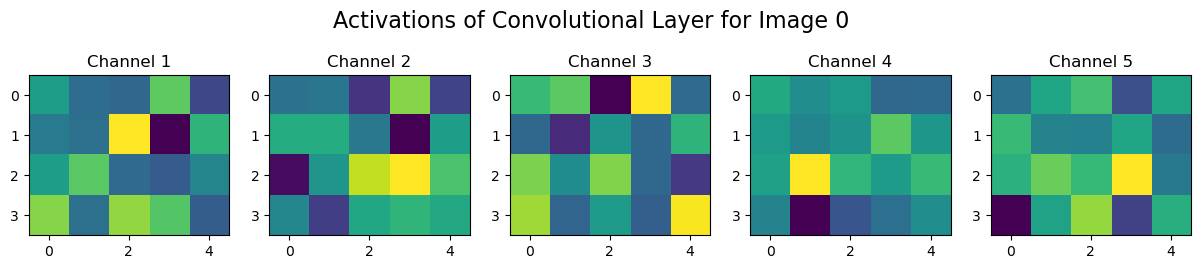

In [ ]:
# Displaying activations of the convolutional layer.

# Index of image to show the activation for.
image_nr = 0

# Number of channels to show.
channel_nr = 5

mm = activation['conv1'].cpu().numpy()

fig, axs = plt.subplots(1, channel_nr, figsize=(15,3))

for i in range(channel_nr):
    axs[i].imshow(mm[image_nr, i, :, :], cmap='viridis')
    axs[i].set_title(f'Channel {i + 1}')

plt.suptitle(f'Activations of Convolutional Layer for Image {image_nr}', fontsize=16)
plt.show(block=False)